In [90]:
import re
import glob
import pickle
import time
import numpy as np
import pandas as pd
import pickle
import dask.array as da
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn import svm
from sklearn import neighbors
from sklearn import naive_bayes
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.gaussian_process import GaussianProcessClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier

from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

from sklearn.externals import joblib

%config InlineBackend.figure_format = 'svg'
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [38]:
def yield_origin_csv(file_type):
    flag = 1
    id_, exinfos_list = [], []
    exinfos_regex = re.compile('<exInfo value="(.*?)"')
    for path in glob.glob("./stage1_dataset/train/{}/*".format(file_type)):
        with open(path, "r") as fp:
            xml = fp.read()
        exinfos = re.findall(exinfos_regex, xml)
        dll_exinfos = [ef.split("\\")[-1].split('.')[0] for ef in exinfos 
                       if ef.endswith(".dll") and ef.startswith("C:")]
        id_.append(path.split(".")[1].split("/")[-1]) 
        exinfos_list.append(" ".join(dll_exinfos))
        
        
        if flag % 300 == 0:
            print(flag)
        flag += 1
    df = pd.DataFrame()
    df["id"] = id_
    df["exinfos"] = exinfos_list
    return df

In [43]:
black_exinfos = yield_origin_csv("black")
white_exinfos = yield_origin_csv("white")
test_exinfos = yield_origin_csv("test")

In [46]:
train_exinfos = pd.concat([white_exinfos, black_exinfos])

In [47]:
train_data_exinfos = train_exinfos["exinfos"]
test_data_exinfos = test_exinfos["exinfos"]

In [57]:
vectorizer = TfidfVectorizer(ngram_range=(1, 5), min_df=3, max_df=0.9)
train_tfidf_features = vectorizer.fit_transform(train_data_exinfos.tolist())
test_tfidf_features = vectorizer.transform(test_data_exinfos.tolist())
with open("exinfos_train_tfidf_features.pkl", "wb") as fp:
    pickle.dump(train_tfidf_features, fp)
with open("exinfos_test_tfidf_features.pkl", "wb") as fp:
    pickle.dump(test_tfidf_features, fp)
    
safe_type = pd.read_csv("safe_type.csv", header=None)

In [53]:
bc_model = BaggingClassifier()
gbc_model = GradientBoostingClassifier()
lr_model = LogisticRegression()
svm_model = svm.LinearSVC()
dt_model = DecisionTreeClassifier()
xgb_model = XGBClassifier(max_depth=7,
                          learning_rate=0.05,
                          n_estimators=1000)

rfc_model = RandomForestClassifier(200)
etc_model = ExtraTreesClassifier()
mnb_model = naive_bayes.MultinomialNB(alpha=0.01)
ada_model = AdaBoostClassifier()

In [54]:
def get_oof(model, x_train, y_train, x_test, n_splits):
    """
    :@param x_train: feature matrix.
    :type x: np.array(M X N) or list(M X N).
    :@param y_train: class label.
    :type y: int.
    :@param x_test: test set feature matrix.
    :type x_test: np.array(M X N) or list(M X N).
    :@param n_splits: K-fold parameter.
    :type n_splits: int.
    """
    n_train, n_test = x_train.shape[0], x_test.shape[0]
    kf = StratifiedKFold(n_splits=n_splits, random_state=0)
    oof_train = np.empty((n_train, ))
    oof_test = np.empty((n_test, ))
    oof_test_skf = np.empty((n_splits, n_test))
    for i, (train_index, test_index) in enumerate(kf.split(x_train, y_train)):
        kf_x_train = x_train[train_index]
        kf_y_train = y_train[train_index]
        kf_x_test = x_train[test_index]
        model.fit(kf_x_train, kf_y_train)
        oof_train[test_index] = model.predict(kf_x_test)
        oof_test_skf[i, :] = model.predict(x_test)
    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

In [58]:

try:
    lr_model_oof_train, lr_model_oof_test = get_oof(lr_model, 
                                                    train_tfidf_features.tolil(), 
                                                    safe_type.values,
                                                    test_tfidf_features.tolil(),
                                                    10)
    with open("exinfos_lr_model_oof_train.csv", "wb") as fp:
        pickle.dump(lr_model_oof_train, fp)
    with open("exinfos_lr_model_oof_test.csv", "wb") as fp:
        pickle.dump(lr_model_oof_test, fp)
    print("lr success!")
except:
    print("lr error!")
try:
    gbc_model_oof_train, gbc_model_oof_test = get_oof(gbc_model, 
                                                      train_tfidf_features.tolil(), 
                                                      safe_type.values,
                                                      test_tfidf_features.tolil(),
                                                      10)
    with open("exinfos_gbc_model_oof_train.csv", "wb") as fp:
        pickle.dump(gbc_model_oof_train, fp)
    with open("exinfos_gbc_model_oof_test.csv", "wb") as fp:
        pickle.dump(gbc_model_oof_test, fp)
    print("gbc success!")
except:
    print("gbc error!")
try:
    bc_model_oof_train, bc_model_oof_test = get_oof(bc_model, 
                                                    train_tfidf_features.tolil(), 
                                                    safe_type.values,
                                                    test_tfidf_features.tolil(),
                                                    10)
    with open("exinfos_bc_model_oof_train.csv", "wb") as fp:
        pickle.dump(bc_model_oof_train, fp)
    with open("exinfos_bc_model_oof_test.csv", "wb") as fp:
        pickle.dump(bc_model_oof_test, fp)
    print("bc success!")
except:
    print("bc error!")
try:
    svm_model_oof_train, svm_model_oof_test = get_oof(svm_model, 
                                                      train_tfidf_features.tolil(), 
                                                      safe_type.values,
                                                      test_tfidf_features.tolil(),
                                                      10)
    with open("exinfos_svm_model_oof_train.csv", "wb") as fp:
        pickle.dump(svm_model_oof_train, fp)
    with open("exinfos_svm_model_oof_test.csv", "wb") as fp:
        pickle.dump(svm_model_oof_test, fp)
    print("svm success!")
except:
    print("svm error!")
try:
    dt_model_oof_train, dt_model_oof_test = get_oof(dt_model, 
                                                      train_tfidf_features.tolil(), 
                                                      safe_type.values,
                                                      test_tfidf_features.tolil(),
                                                      10)
    with open("exinfos_dt_model_oof_train.csv", "wb") as fp:
        pickle.dump(dt_model_oof_train, fp)
    with open("exinfos_dt_model_oof_test.csv", "wb") as fp:
        pickle.dump(dt_model_oof_test, fp)
    print("dt success!")
except:
    print("dt error!")
try:
    xgb_model_oof_train, xgb_model_oof_test = get_oof(xgb_model, 
                                                      train_tfidf_features.tolil(), 
                                                      safe_type.values,
                                                      test_tfidf_features.tolil(),
                                                      10)
    with open("exinfos_xgb_model_oof_train.csv", "wb") as fp:
        pickle.dump(xgb_model_oof_train, fp)
    with open("exinfos_xgb_model_oof_test.csv", "wb") as fp:
        pickle.dump(xgb_model_oof_test, fp)
    print("xgb success!")
except:
    print("xgb error!")
try:
    rfc_model_oof_train, rfc_model_oof_test = get_oof(rfc_model, 
                                                      train_tfidf_features.tolil(), 
                                                      safe_type.values,
                                                      test_tfidf_features.tolil(),
                                                      10)
    with open("exinfos_rfc_model_oof_train.csv", "wb") as fp:
        pickle.dump(rfc_model_oof_train, fp)
    with open("exinfos_rfc_model_oof_test.csv", "wb") as fp:
        pickle.dump(rfc_model_oof_test, fp)
    print("rfc success!")
except:
    print("rfc error!")
    
try:
    etc_model_oof_train, etc_model_oof_test = get_oof(etc_model, 
                                                      train_tfidf_features.tolil(), 
                                                      safe_type.values,
                                                      test_tfidf_features.tolil(),
                                                      10)
    with open("exinfos_etc_model_oof_train.csv", "wb") as fp:
        pickle.dump(etc_model_oof_train, fp)
    with open("exinfos_etc_model_oof_test.csv", "wb") as fp:
        pickle.dump(etc_model_oof_test, fp)
    print("etc success!")
except:
    print("etc error!")
try:
    mnb_model_oof_train, mnb_model_oof_test = get_oof(mnb_model, 
                                                      train_tfidf_features.tolil(), 
                                                      safe_type.values,
                                                      test_tfidf_features.tolil(),
                                                      10)
    with open("exinfos_mnb_model_oof_train.csv", "wb") as fp:
        pickle.dump(mnb_model_oof_train, fp)
    with open("exinfos_mnb_model_oof_test.csv", "wb") as fp:
        pickle.dump(mnb_model_oof_test, fp)
    print("mnb success!")
except:
    print("mnb error!")
    
try:
    ada_model_oof_train, ada_model_oof_test = get_oof(ada_model, 
                                                      train_tfidf_features.tolil(), 
                                                      safe_type.values,
                                                      test_tfidf_features.tolil(),
                                                      10)
    with open("exinfos_ada_model_oof_train.csv", "wb") as fp:
        pickle.dump(ada_model_oof_train, fp)
    with open("exinfos_ada_model_oof_test.csv", "wb") as fp:
        pickle.dump(ada_model_oof_test, fp)
    print("ada success!")
except:
    print("ada error!")


exinfos_stacking_train_10 = np.hstack([lr_model_oof_train, gbc_model_oof_train, bc_model_oof_train,
                            svm_model_oof_train, xgb_model_oof_train, dt_model_oof_train,
                            rfc_model_oof_train, etc_model_oof_train, mnb_model_oof_train,
                            ada_model_oof_train])
exinfos_stacking_test_10 = np.hstack([lr_model_oof_test, gbc_model_oof_test, bc_model_oof_test,
                           svm_model_oof_test, xgb_model_oof_test, dt_model_oof_test,
                           rfc_model_oof_test, etc_model_oof_test, mnb_model_oof_test,
                           ada_model_oof_test])
with open("exinfos_stacking_train_10.pkl", "wb") as fp:
    pickle.dump(exinfos_stacking_train_10, fp)
    
with open("exinfos_stacking_test_10.pkl", "wb") as fp:
    pickle.dump(exinfos_stacking_test_10, fp)

lr success!
gbc success!
bc success!
svm success!
dt success!
xgb success!
rfc success!
etc success!
mnb success!
ada success!


In [100]:
def plot(test_label, y_pred, model):
    font = {"color": "darkred",
            "size": 13, 
            "family" : "serif"}

    accs = accuracy_score(test_label, y_pred)
    fpr, tpr, _ = metrics.roc_curve(test_label,  y_pred)
    auc = metrics.roc_auc_score(test_label, y_pred)
    plt.style.use("fivethirtyeight")
    fig, ax = plt.subplots()
    ax.plot(fpr, tpr, label="{}, auc=".format(model)+str(auc), color='green', linewidth=2)
    ax.set_title("ROC curve", fontdict=font)
    leg = ax.legend(loc="best")
    text = leg.get_texts()
    _ = plt.setp(text, color="blue") 

In [77]:
train_data, test_data, train_label, test_label = train_test_split(train, 
                                                                  safe_type, 
                                                                  test_size=0.2, 
                                                                  random_state=1)

In [78]:
model = XGBClassifier(n_estimators=1000, max_depth=7, learning_rate=0.05) 
model.fit(train_data, train_label)  
y_pred = model.predict(test_data)

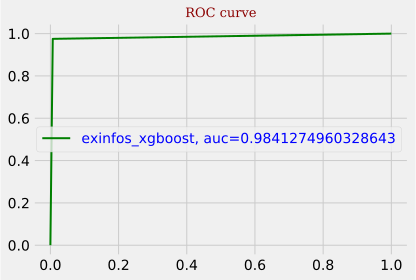

In [79]:
plot(test_label, y_pred, "exinfos_xgboost")

In [70]:
api_name_ret_value_train = pd.read_pickle("api_name_and_ret_value_stacked_mix_train.pkl")
api_name_ret_value_test = pd.read_pickle("api_name_and_ret_value_stacked_mix_test.pkl")

In [73]:
api_name_ret_value_train.shape

(30000, 20)

In [74]:
exinfos_stacking_train_10.shape

(30000, 10)

In [75]:
train = np.hstack([api_name_ret_value_train, exinfos_stacking_train_10])
test = np.hstack([api_name_ret_value_test, exinfos_stacking_test_10])

In [80]:

try:
    lr_model_oof_train, lr_model_oof_test = get_oof(lr_model, 
                                                    train, 
                                                    safe_type.values,
                                                   test,
                                                    10)
    with open("layer2_lr_model_oof_train.csv", "wb") as fp:
        pickle.dump(lr_model_oof_train, fp)
    with open("layer2_lr_model_oof_test.csv", "wb") as fp:
        pickle.dump(lr_model_oof_test, fp)
    print("lr success!")
except:
    print("lr error!")
try:
    gbc_model_oof_train, gbc_model_oof_test = get_oof(gbc_model, 
                                                      train, 
                                                      safe_type.values,
                                                     test,
                                                      10)
    with open("layer2_gbc_model_oof_train.csv", "wb") as fp:
        pickle.dump(gbc_model_oof_train, fp)
    with open("layer2_gbc_model_oof_test.csv", "wb") as fp:
        pickle.dump(gbc_model_oof_test, fp)
    print("gbc success!")
except:
    print("gbc error!")
try:
    bc_model_oof_train, bc_model_oof_test = get_oof(bc_model, 
                                                    train, 
                                                    safe_type.values,
                                                   test,
                                                    10)
    with open("layer2_bc_model_oof_train.csv", "wb") as fp:
        pickle.dump(bc_model_oof_train, fp)
    with open("layer2_bc_model_oof_test.csv", "wb") as fp:
        pickle.dump(bc_model_oof_test, fp)
    print("bc success!")
except:
    print("bc error!")
try:
    svm_model_oof_train, svm_model_oof_test = get_oof(svm_model, 
                                                      train, 
                                                      safe_type.values,
                                                     test,
                                                      10)
    with open("layer2_svm_model_oof_train.csv", "wb") as fp:
        pickle.dump(svm_model_oof_train, fp)
    with open("layer2_svm_model_oof_test.csv", "wb") as fp:
        pickle.dump(svm_model_oof_test, fp)
    print("svm success!")
except:
    print("svm error!")
try:
    dt_model_oof_train, dt_model_oof_test = get_oof(dt_model, 
                                                      train, 
                                                      safe_type.values,
                                                     test,
                                                      10)
    with open("layer2_dt_model_oof_train.csv", "wb") as fp:
        pickle.dump(dt_model_oof_train, fp)
    with open("layer2_dt_model_oof_test.csv", "wb") as fp:
        pickle.dump(dt_model_oof_test, fp)
    print("dt success!")
except:
    print("dt error!")

try:
    rfc_model_oof_train, rfc_model_oof_test = get_oof(rfc_model, 
                                                      train, 
                                                      safe_type.values,
                                                     test,
                                                      10)
    with open("layer2_rfc_model_oof_train.csv", "wb") as fp:
        pickle.dump(rfc_model_oof_train, fp)
    with open("layer2_rfc_model_oof_test.csv", "wb") as fp:
        pickle.dump(rfc_model_oof_test, fp)
    print("rfc success!")
except:
    print("rfc error!")
    
try:
    etc_model_oof_train, etc_model_oof_test = get_oof(etc_model, 
                                                      train, 
                                                      safe_type.values,
                                                     test,
                                                      10)
    with open("layer2_etc_model_oof_train.csv", "wb") as fp:
        pickle.dump(etc_model_oof_train, fp)
    with open("layer2_etc_model_oof_test.csv", "wb") as fp:
        pickle.dump(etc_model_oof_test, fp)
    print("etc success!")
except:
    print("etc error!")
try:
    mnb_model_oof_train, mnb_model_oof_test = get_oof(mnb_model, 
                                                      train, 
                                                      safe_type.values,
                                                     test,
                                                      10)
    with open("layer2_mnb_model_oof_train.csv", "wb") as fp:
        pickle.dump(mnb_model_oof_train, fp)
    with open("layer2_mnb_model_oof_test.csv", "wb") as fp:
        pickle.dump(mnb_model_oof_test, fp)
    print("mnb success!")
except:
    print("mnb error!")
    
try:
    ada_model_oof_train, ada_model_oof_test = get_oof(ada_model, 
                                                      train, 
                                                      safe_type.values,
                                                     test,
                                                      10)
    with open("layer2_ada_model_oof_train.csv", "wb") as fp:
        pickle.dump(ada_model_oof_train, fp)
    with open("layer2_ada_model_oof_test.csv", "wb") as fp:
        pickle.dump(ada_model_oof_test, fp)
    print("ada success!")
except:
    print("ada error!")

try:
    xgb_model_oof_train, xgb_model_oof_test = get_oof(xgb_model, 
                                                      train, 
                                                      safe_type.values,
                                                     test,
                                                      10)
    with open("layer2_xgb_model_oof_train.csv", "wb") as fp:
        pickle.dump(xgb_model_oof_train, fp)
    with open("layer2_xgb_model_oof_test.csv", "wb") as fp:
        pickle.dump(xgb_model_oof_test, fp)
    print("xgb success!")
except:
    print("xgb error!")

layer2_stacking_train_10 = np.hstack([lr_model_oof_train, gbc_model_oof_train, bc_model_oof_train,
                                        svm_model_oof_train, xgb_model_oof_train, dt_model_oof_train,
                                        rfc_model_oof_train, etc_model_oof_train, mnb_model_oof_train,
                                        ada_model_oof_train])
layer2_stacking_test_10 = np.hstack([lr_model_oof_test, gbc_model_oof_test, bc_model_oof_test,
                                       svm_model_oof_test, xgb_model_oof_test, dt_model_oof_test,
                                       rfc_model_oof_test, etc_model_oof_test, mnb_model_oof_test,
                                       ada_model_oof_test])
with open("layer2_stacking_train_10.pkl", "wb") as fp:
    pickle.dump(layer2_stacking_train_10, fp)
    
with open("layer2_stacking_test_10.pkl", "wb") as fp:
    pickle.dump(layer2_stacking_test_10, fp)

lr success!
gbc success!
bc success!
svm success!
dt success!
rfc success!
etc success!
mnb success!
ada success!
xgb success!


In [81]:
train_data, test_data, train_label, test_label = train_test_split(layer2_stacking_train_10, 
                                                                  safe_type, 
                                                                  test_size=0.2, 
                                                                  random_state=1)

In [104]:
model = XGBClassifier(n_estimators=70, max_depth=7, learning_rate=0.05) 
model.fit(layer2_stacking_train_10, safe_type.values)  
y_pred = model.predict(layer2_stacking_test_10)

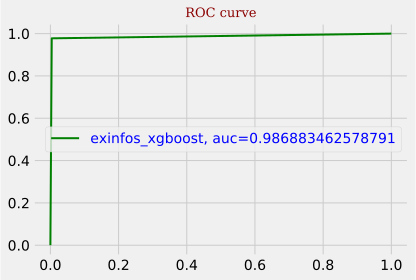

In [95]:
plot(test_label, y_pred, "exinfos_xgboost")

In [105]:
y_pred.sum()

4941

In [106]:
id_ = pd.read_csv("test_features.csv")["id"]
result = pd.DataFrame()
result["id"] = id_
result["safe_type"] = y_pred

In [107]:
result.to_csv("result.csv", encoding="utf-8", index=False)

In [88]:
layer2_train = pd.read_pickle("layer2_stacking_train_10.pkl")
layer2_test = pd.read_pickle("layer2_stacking_test_10.pkl")
train_features = pd.read_csv("train_features.csv").iloc[:, 2:]
test_features = pd.read_csv("test_features.csv").iloc[:, 1:]
safe_type = pd.read_csv("train_features.csv")["safe_type"]

In [92]:
scaler = MinMaxScaler()
scaler_train_features = scaler.fit_transform(train_features.values)
scaler_test_features = scaler.transform(test_features.values)

In [94]:
train = np.hstack([layer2_train, scaler_train_features])
test = np.hstack([layer2_test, scaler_test_features])

In [97]:
train_data, test_data, train_label, test_label = train_test_split(train, 
                                                                  safe_type, 
                                                                  test_size=0.2, 
                                                                  random_state=1)

In [146]:
# model = XGBClassifier(n_estimators=640, max_depth=7, learning_rate=0.05) 
model = XGBClassifier(n_estimators=640, max_depth=7, learning_rate=0.05) 
model.fit(train, safe_type.values)  
y_pred = model.predict(test)

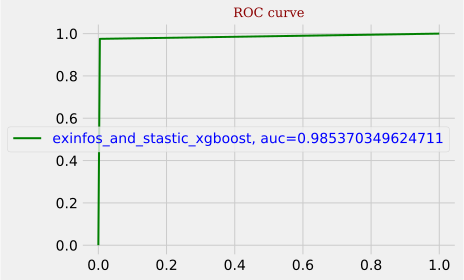

In [101]:
plot(test_label, y_pred, "exinfos_and_stastic_xgboost")

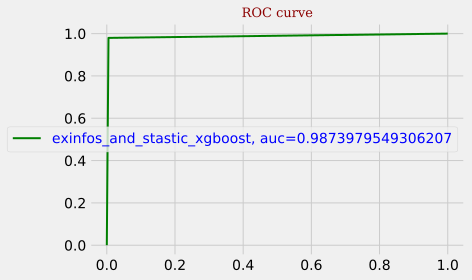

In [121]:
plot(test_label, y_pred, "exinfos_and_stastic_xgboost")

In [147]:
y_pred.sum()

4931

In [150]:
id_ = pd.read_csv("test_features.csv")["id"]
result = pd.DataFrame()
result["id"] = id_
result["safe_type"] = y_pred

In [151]:
result.to_csv("result.csv", encoding="utf-8", index=False)

In [165]:
apys = [1, 2, 2, 4, 5, 6, 2, 2, 2, 5, 6, 2]
times = range(1, 13)

In [164]:
for i, apy, time in enumerate(zip(apys, times)):
    if spy > 3:
        for sub in apys[i+1:]:
            if sub 

array([ 4,  5,  6, 10, 11])